In [ ]:
# !wget -q https://git.io/JGc31 -O ucf101_top5.tar.gz
# !tar xf ucf101_top5.tar.gz

In [1]:
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


In [2]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [3]:
!cp /content/gdrive/MyDrive/sem7btp/RGB.zip /content

In [4]:
# !wget http://www.utdallas.edu/~kehtar/UTD-MAD/RGB.zip -O RGB.zip

In [5]:
!unzip RGB.zip -d /content/

Archive:  RGB.zip
   creating: /content/RGB/
  inflating: /content/RGB/a10_s1_t1_color.avi  
  inflating: /content/RGB/a10_s1_t2_color.avi  
  inflating: /content/RGB/a10_s1_t3_color.avi  
  inflating: /content/RGB/a10_s1_t4_color.avi  
  inflating: /content/RGB/a10_s2_t1_color.avi  
  inflating: /content/RGB/a10_s2_t2_color.avi  
  inflating: /content/RGB/a10_s2_t3_color.avi  
  inflating: /content/RGB/a10_s2_t4_color.avi  
  inflating: /content/RGB/a10_s3_t1_color.avi  
  inflating: /content/RGB/a10_s3_t2_color.avi  
  inflating: /content/RGB/a10_s3_t3_color.avi  
  inflating: /content/RGB/a10_s3_t4_color.avi  
  inflating: /content/RGB/a10_s4_t1_color.avi  
  inflating: /content/RGB/a10_s4_t2_color.avi  
  inflating: /content/RGB/a10_s4_t3_color.avi  
  inflating: /content/RGB/a10_s4_t4_color.avi  
  inflating: /content/RGB/a10_s5_t1_color.avi  
  inflating: /content/RGB/a10_s5_t2_color.avi  
  inflating: /content/RGB/a10_s5_t3_color.avi  
  inflating: /content/RGB/a10_s5_t4_color.a

In [6]:
from tensorflow_docs.vis import embed
from tensorflow.keras import layers
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os

In [7]:
MAX_SEQ_LENGTH = 50
NUM_FEATURES = 1024
IMG_SIZE = 224

EPOCHS = 5

In [ ]:
# train_df = pd.read_csv("train.csv")
# test_df = pd.read_csv("test.csv")

# print(f"Total videos for training: {len(train_df)}")
# print(f"Total videos for testing: {len(test_df)}")

In [8]:
from glob import glob
all_files = []
for i in glob("/content/RGB/*"):
  all_files.append(i)

In [9]:
all_tags = [i.split("_")[0].split("/")[-1] for i in all_files]
all_tags

['a7',
 'a17',
 'a19',
 'a17',
 'a1',
 'a9',
 'a4',
 'a11',
 'a10',
 'a19',
 'a22',
 'a25',
 'a23',
 'a6',
 'a17',
 'a25',
 'a17',
 'a23',
 'a23',
 'a18',
 'a3',
 'a5',
 'a13',
 'a16',
 'a20',
 'a26',
 'a10',
 'a26',
 'a24',
 'a9',
 'a4',
 'a27',
 'a17',
 'a26',
 'a4',
 'a3',
 'a16',
 'a22',
 'a15',
 'a12',
 'a14',
 'a2',
 'a12',
 'a18',
 'a4',
 'a26',
 'a12',
 'a20',
 'a15',
 'a6',
 'a1',
 'a23',
 'a5',
 'a19',
 'a21',
 'a15',
 'a3',
 'a27',
 'a15',
 'a11',
 'a16',
 'a24',
 'a27',
 'a3',
 'a3',
 'a20',
 'a1',
 'a15',
 'a12',
 'a5',
 'a7',
 'a12',
 'a17',
 'a15',
 'a4',
 'a14',
 'a27',
 'a6',
 'a7',
 'a20',
 'a25',
 'a8',
 'a7',
 'a18',
 'a2',
 'a14',
 'a12',
 'a5',
 'a25',
 'a7',
 'a25',
 'a17',
 'a3',
 'a27',
 'a22',
 'a26',
 'a20',
 'a19',
 'a20',
 'a21',
 'a11',
 'a3',
 'a24',
 'a24',
 'a27',
 'a14',
 'a27',
 'a7',
 'a17',
 'a4',
 'a9',
 'a18',
 'a19',
 'a19',
 'a19',
 'a5',
 'a4',
 'a4',
 'a1',
 'a11',
 'a10',
 'a17',
 'a24',
 'a22',
 'a14',
 'a8',
 'a14',
 'a25',
 'a16',
 'a25',


In [10]:
utd_df = pd.DataFrame(data={"video_name":all_files, "tag":all_tags})

In [18]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(utd_df, stratify=utd_df['tag'], test_size=0.33, random_state=42)

In [19]:
train_df['tag'].shape

(576,)

In [20]:
center_crop_layer = layers.CenterCrop(IMG_SIZE, IMG_SIZE)

def crop_center(frame):
    cropped = center_crop_layer(frame[None, ...])
    cropped = cropped.numpy().squeeze()
    return cropped


# Following method is modified from this tutorial:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def load_video(path, max_frames=0):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center(frame)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)


def build_feature_extractor():
    feature_extractor = keras.applications.DenseNet121(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.densenet.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()


# Label preprocessing with StringLookup.
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["tag"]), mask_token=None
)
print(label_processor.get_vocabulary())


def prepare_all_videos(df):#, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values
    labels = label_processor(labels[..., None]).numpy()
    

    # `frame_features` are what we will feed to our sequence model.
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        print(idx,path)
        # Gather all its frames and add a batch dimension.
        frames = load_video(path)#os.path.join(root_dir, path))

        # Pad shorter videos.
        try:
          if len(frames) < MAX_SEQ_LENGTH:
              diff = MAX_SEQ_LENGTH - len(frames)
              padding = np.zeros((diff, IMG_SIZE, IMG_SIZE, 3))
              frames = np.concatenate((frames, padding))
        except:
          print(diff)
          print(frames.shape,padding.shape)

        frames = frames[None, ...]

        # Initialize placeholder to store the features of the current video.
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                if np.mean(batch[j, :]) > 0.0:
                    temp_frame_features[i, j, :] = feature_extractor.predict(
                        batch[None, j, :]
                    )

                else:
                    temp_frame_features[i, j, :] = 0.0

        frame_features[idx,] = temp_frame_features.squeeze()

    return frame_features, labels

['a1', 'a10', 'a11', 'a12', 'a13', 'a14', 'a15', 'a16', 'a17', 'a18', 'a19', 'a2', 'a20', 'a21', 'a22', 'a23', 'a24', 'a25', 'a26', 'a27', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'a9']


In [ ]:
train_data, train_labels = prepare_all_videos(train_df)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 48ms/step
473 /content/RGB/a26_s6_t1_color.avi
1/1 [==============================] - 0s 45ms/step
474 /content/RGB/a12_s4_t3_color.avi
1/1 [==============================] - 0s 57ms/step
475 /content/RGB/a5_s7_t4_color.avi
1/1 [==============================] - 0s 47ms/step
476 /content/RGB/a18_s5_t2_color.avi
1/1 [==============================] - 0s 38ms/step
477 /content/RGB/a1_s8_t2_color.avi
1/1 [==============================] - 0s 52ms/step
478 /content/RGB/a15_s5_t1_color.avi
1/1 [==============================] - 0s 35ms/step
479 /content/RGB/a10_s1_t1_color.avi
1/1 [==============================] - 0s 38ms/step
480 /content/RGB/a21_s2_t2_color.avi
1/1 [==============================] - 0s 47ms/step
481 /content/RGB/a9_s6_t1_color.avi
1/1 [==============================] - 0s 68ms/step
482 /content/RGB/a7_s8_t3_color.avi
1/1 [==============================] - 0s 52ms/step
483 /conten

In [ ]:
train_data.shape

(576, 50, 1024)

In [ ]:
with open('/content/gdrive/MyDrive/sem7btp/utd_train_data_224_50.npy', 'wb') as f:
  np.save(f, train_data)

In [ ]:
with open('/content/gdrive/MyDrive/sem7btp/utd_train_labels_224_50.npy', 'wb') as f:
  np.save(f, train_labels)

In [11]:
# with open('/content/gdrive/MyDrive/sem7btp/utd_train_labels_224_50.npy', 'wb') as f:
train_data = np.load('/content/gdrive/MyDrive/sem7btp/utd_train_data_224_50.npy')
train_labels = np.load('/content/gdrive/MyDrive/sem7btp/utd_train_labels_224_50.npy')

In [ ]:
test_data, test_labels = prepare_all_videos(test_df)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 38ms/step
41 /content/RGB/a21_s7_t4_color.avi
1/1 [==============================] - 0s 36ms/step
42 /content/RGB/a11_s7_t4_color.avi
1/1 [==============================] - 0s 56ms/step
43 /content/RGB/a11_s7_t1_color.avi
1/1 [==============================] - 0s 36ms/step
44 /content/RGB/a3_s8_t1_color.avi
1/1 [==============================] - 0s 67ms/step
45 /content/RGB/a26_s1_t3_color.avi
1/1 [==============================] - 0s 37ms/step
46 /content/RGB/a24_s5_t4_color.avi
1/1 [==============================] - 0s 35ms/step
47 /content/RGB/a5_s6_t3_color.avi
1/1 [==============================] - 0s 33ms/step
48 /content/RGB/a5_s7_t1_color.avi
1/1 [==============================] - 0s 43ms/step
49 /content/RGB/a11_s1_t3_color.avi
1/1 [==============================] - 0s 37ms/step
50 /content/RGB/a12_s7_t4_color.avi
1/1 [==============================] - 0s 41ms/step
51 /content/RGB/a17_

In [ ]:
with open('/content/gdrive/MyDrive/sem7btp/utd_test_data_224_50.npy', 'wb') as f:
  np.save(f, test_data)
with open('/content/gdrive/MyDrive/sem7btp/utd_test_labels_224_50.npy', 'wb') as f:
  np.save(f, test_labels)

In [12]:
test_data = np.load('/content/gdrive/MyDrive/sem7btp/utd_test_data_224_50.npy')
test_labels = np.load('/content/gdrive/MyDrive/sem7btp/utd_test_labels_224_50.npy')

In [ ]:
# !wget -q https://git.io/JZmf4 -O top5_data_prepared.tar.gz
# !tar xf top5_data_prepared.tar.gz

In [ ]:
# train_data, train_labels = np.load("train_data.npy"), np.load("train_labels.npy")
# test_data, test_labels = np.load("test_data.npy"), np.load("test_labels.npy")

# print(f"Frame features in train set: {train_data.shape}")

Frame features in train set: (594, 20, 1024)


In [ ]:
# test_data[0]

array([[4.4310736e-04, 2.8189668e-03, 3.4897940e-03, ..., 7.0448476e-01,
        1.9908323e+00, 1.3066864e+00],
       [4.4161378e-04, 3.0781918e-03, 3.4470989e-03, ..., 4.9877357e-01,
        1.9352850e+00, 1.7995611e+00],
       [4.2726495e-04, 3.2129823e-03, 3.5145392e-03, ..., 7.3793834e-01,
        2.3247457e+00, 1.2005497e+00],
       ...,
       [4.0682819e-04, 3.0987712e-03, 3.2149851e-03, ..., 5.9589022e-01,
        2.1259639e+00, 1.3000907e+00],
       [4.2539660e-04, 3.4505408e-03, 3.3747610e-03, ..., 7.5611931e-01,
        2.0981059e+00, 1.4345844e+00],
       [4.0548306e-04, 3.9193975e-03, 3.7462718e-03, ..., 1.2269558e+00,
        2.2060153e+00, 1.6544119e+00]], dtype=float32)

In [21]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim
        )
        self.sequence_length = sequence_length
        self.output_dim = output_dim

    def call(self, inputs):
        # The inputs are of shape: `(batch_size, frames, num_features)`
        length = tf.shape(inputs)[1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_positions = self.position_embeddings(positions)
        return inputs + embedded_positions

    def compute_mask(self, inputs, mask=None):
        mask = tf.reduce_any(tf.cast(inputs, "bool"), axis=-1)
        return mask

In [22]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        # self.dense_1 = layers.Dense(embed_dim, activation=tf.nn.gelu)
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.4
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation=tf.nn.gelu), layers.Dense(embed_dim),]
        )
        # self.dropout_1 = layers.Dropout(0.3)
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        # inputs = self.dense_1(inputs)
        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

In [23]:
def get_compiled_model():
    sequence_length = MAX_SEQ_LENGTH
    embed_dim = NUM_FEATURES
    dense_dim = 32
    num_heads = 1
    classes = len(label_processor.get_vocabulary())

    inputs = keras.Input(shape=(None, None))
    x = PositionalEmbedding(
        sequence_length, embed_dim, name="frame_position_embedding"
    )(inputs)
    x = TransformerEncoder(embed_dim, dense_dim, num_heads, name="transformer_layer")(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )
    return model


def run_experiment():
    filepath = "/tmp/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    model = get_compiled_model()
    history = model.fit(
        train_data,
        train_labels,
        validation_split=0.15,
        epochs=100,
        callbacks=[checkpoint],
    )

    model.load_weights(filepath)
    _, accuracy = model.evaluate(test_data, test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return model

In [24]:
trained_model = run_experiment()

Epoch 1/100
16/16 [==============================] - ETA: 0s - loss: 6.1790 - accuracy: 0.0286
Epoch 1: val_loss improved from inf to 3.77832, saving model to /tmp/video_classifier
16/16 [==============================] - 10s 95ms/step - loss: 6.1790 - accuracy: 0.0286 - val_loss: 3.7783 - val_accuracy: 0.0345
Epoch 2/100
14/16 [=========================>....] - ETA: 0s - loss: 4.4034 - accuracy: 0.0446
Epoch 2: val_loss improved from 3.77832 to 3.55198, saving model to /tmp/video_classifier
16/16 [==============================] - 1s 52ms/step - loss: 4.4067 - accuracy: 0.0429 - val_loss: 3.5520 - val_accuracy: 0.0575
Epoch 3/100
16/16 [==============================] - ETA: 0s - loss: 4.2449 - accuracy: 0.0286
Epoch 3: val_loss improved from 3.55198 to 3.45476, saving model to /tmp/video_classifier
16/16 [==============================] - 1s 50ms/step - loss: 4.2449 - accuracy: 0.0286 - val_loss: 3.4548 - val_accuracy: 0.0115
Epoch 4/100
14/16 [=========================>....] - ETA: 

Test video path: /content/RGB/RGB/a18_s7_t3_color.avi
1/1 [==============================] - 0s 272ms/step
  a26: 13.45%
  a19:  9.12%
  a20:  6.17%
  a14:  5.44%
  a8:  5.25%
  a22:  4.86%
  a9:  4.71%
  a18:  4.68%
  a1:  4.65%
  a13:  4.55%
  a15:  4.13%
  a4:  4.11%
  a3:  3.30%
  a7:  3.26%
  a24:  2.88%
  a23:  2.87%
  a21:  2.75%
  a27:  2.28%
  a10:  1.92%
  a25:  1.72%
  a17:  1.64%
  a16:  1.60%
  a5:  1.42%
  a12:  1.05%
  a2:  0.82%
  a11:  0.82%
  a6:  0.54%



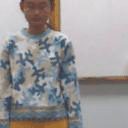

In [ ]:
def prepare_single_video(frames):
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    # Pad shorter videos.
    if len(frames) < MAX_SEQ_LENGTH:
        diff = MAX_SEQ_LENGTH - len(frames)
        padding = np.zeros((diff, IMG_SIZE, IMG_SIZE, 3))
        frames = np.concatenate(frames, padding)

    frames = frames[None, ...]

    # Extract features from the frames of the current video.
    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            if np.mean(batch[j, :]) > 0.0:
                frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
            else:
                frame_features[i, j, :] = 0.0

    return frame_features


def predict_action(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("test", path))
    frame_features = prepare_single_video(frames)
    probabilities = trained_model.predict(frame_features)[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames


# This utility is for visualization.
# Referenced from:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")


test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = predict_action(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])